In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import sys

sys.path.append('../../../thirdParty')
sys.path.append('../../../src')
from src.CFDNNetAdaptV4 import CFDNNetAdapt
from thirdParty.rbf_keras.rbflayer import RBFLayer, InitCentersRandom
from thirdParty.rbf_keras.kmeans_initializer import InitCentersKMeans

In [2]:
n_inputs = 14
n_outputs = 1
n_objectives = 2

In [3]:
def plot_regression_line(model, x, y):
    plt.scatter(y, model.predict(x), color = "m", marker = "o", s = 30)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [4]:
def load_and_scale_data(dataDir, dataNm, n_inputs, n_outputs):
    """ function to load samples and scale them to be in <0,1> """

    # load samples
    with open(dataDir + dataNm, 'r') as file:
        data = file.readlines()

    # remove annotation row
    data = data[1::]

    # convert the data to numpy array
    dataNum = []
    for line in data:
        lineSpl = line.split(',')
        row = []
        for value in lineSpl:
            row.append(float(value))
        dataNum.append(row)

    dataNum = np.array(dataNum)

    # scale the data
    colMins = np.min(dataNum, axis=0)
    colMaxs = np.max(dataNum, axis=0)
    for rowInd in range(dataNum.shape[0]):
        for colInd in range(dataNum.shape[1]):
            dataNum[rowInd, colInd] = (dataNum[rowInd, colInd] - colMins[colInd]) / (
                    colMaxs[colInd] - colMins[colInd])

    # split and transpose
    source = dataNum[:, :n_inputs]
    target = dataNum[:, n_inputs:n_inputs + n_outputs]

    return source, target, colMins, colMaxs

In [5]:
X, y, smpMins, smpMaxs = load_and_scale_data('../00_prepCFDData/14_LConv2CPLDiff4CP/', '10_platypusCFDAllSolutions.dat', 14, 1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [7]:
def get_rbf_layer(n_hidden_neurons, initializer, betas):
    return RBFLayer(n_hidden_neurons,
                    initializer=initializer,
                    betas=betas,
                    input_shape=(n_inputs,))

In [8]:
def create_model(n_hidden_neurons, initializer, betas):
    model = Sequential()
    model.add(get_rbf_layer(n_hidden_neurons, initializer, betas))
    model.add(Dense(n_outputs))
    return model
    

In [11]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'initializer': [InitCentersRandom(X), InitCentersKMeans(X)],
    # 'initializer': [InitCentersKMeans(X)],
    'betas': [1.0, 2.0, 3.0],
    'n_hidden_neurons': [32, 64],
    # 'optimizer': [RMSprop(), 'adam', 'sgd']
    'optimizer': [RMSprop()]
}

comb = ParameterGrid(param_grid)
print(list(comb))

[{'betas': 1.0, 'initializer': <thirdParty.rbf_keras.rbflayer.InitCentersRandom object at 0x30004bb90>, 'n_hidden_neurons': 32, 'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x177752790>}, {'betas': 1.0, 'initializer': <thirdParty.rbf_keras.rbflayer.InitCentersRandom object at 0x30004bb90>, 'n_hidden_neurons': 64, 'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x177752790>}, {'betas': 1.0, 'initializer': <thirdParty.rbf_keras.kmeans_initializer.InitCentersKMeans object at 0x300012590>, 'n_hidden_neurons': 32, 'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x177752790>}, {'betas': 1.0, 'initializer': <thirdParty.rbf_keras.kmeans_initializer.InitCentersKMeans object at 0x300012590>, 'n_hidden_neurons': 64, 'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x177752790>}, {'betas': 2.0, 'initializer': <thirdParty.rbf_keras.rbflayer.InitCentersRandom object at 0x30004bb90>, 'n_hidden_neurons': 32, 'optimizer':

In [12]:
nets = []
val_losses = []
train_losses = []
histories = []
for params in comb:
    print(f"Training model with params: {params}")
    model = create_model(params['n_hidden_neurons'], params['initializer'], params['betas'])
    model.compile(loss='mean_squared_error', optimizer=params['optimizer'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=75, verbose=1, mode='auto')
    history = model.fit(X_train, y_train, batch_size=512, epochs=10000, verbose=0, validation_data=(X_val, y_val), validation_freq=1, callbacks=[early_stopping])
    histories.append(history)
    val_losses.append(model.evaluate(X_val, y_val))
    train_losses.append(history.history['loss'][-1])
    nets.append(model)
    
best_params = comb[np.argmin(val_losses)]
best_params

Training model with params: {'betas': 1.0, 'initializer': <thirdParty.rbf_keras.rbflayer.InitCentersRandom object at 0x30004bb90>, 'n_hidden_neurons': 32, 'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x177752790>}
Epoch 3718: early stopping
73/73 [==============================] - 0s 556us/step - loss: 0.0016
Training model with params: {'betas': 1.0, 'initializer': <thirdParty.rbf_keras.rbflayer.InitCentersRandom object at 0x30004bb90>, 'n_hidden_neurons': 64, 'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x177752790>}
Epoch 571: early stopping
73/73 [==============================] - 0s 574us/step - loss: 0.0026
Training model with params: {'betas': 1.0, 'initializer': <thirdParty.rbf_keras.kmeans_initializer.InitCentersKMeans object at 0x300012590>, 'n_hidden_neurons': 32, 'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x177752790>}
Epoch 568: early stopping
73/73 [==============================] - 0s 527us/step - los

{'optimizer': <keras.src.optimizers.legacy.rmsprop.RMSprop at 0x177752790>,
 'n_hidden_neurons': 64,
 'initializer': <thirdParty.rbf_keras.rbflayer.InitCentersRandom at 0x30004bb90>,
 'betas': 3.0}

Text(0, 0.5, 'Mean Squared Error')

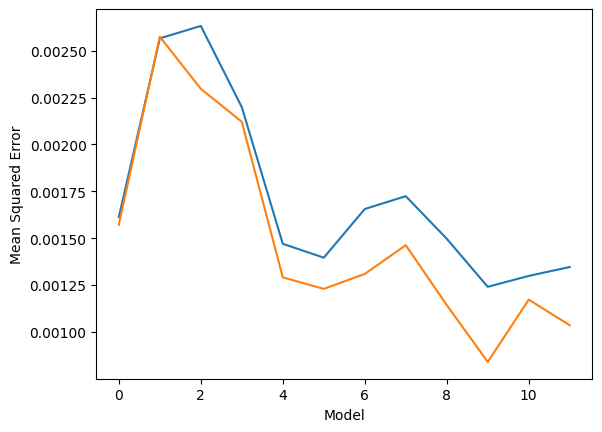

In [13]:
plt.plot(val_losses)
plt.plot(train_losses)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')

In [14]:
model = nets[np.argmin(val_losses)]
history = histories[np.argmin(val_losses)]
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_11 (RBFLayer)     (None, 64)                960       
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1025 (4.00 KB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


73/73 [==============================] - 0s 575us/step


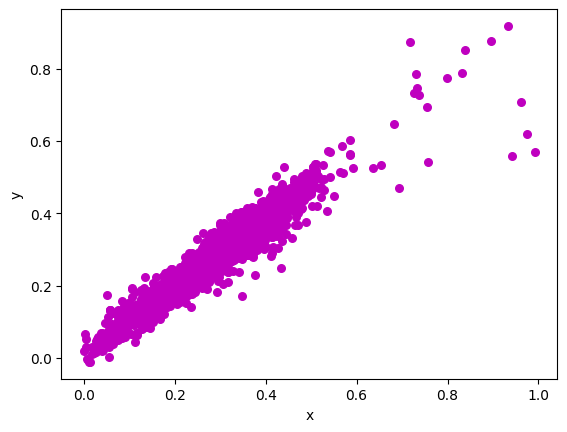

In [15]:
plot_regression_line(model, X_val, y_val)

In [16]:
n_hidden_neurons = best_params['n_hidden_neurons']

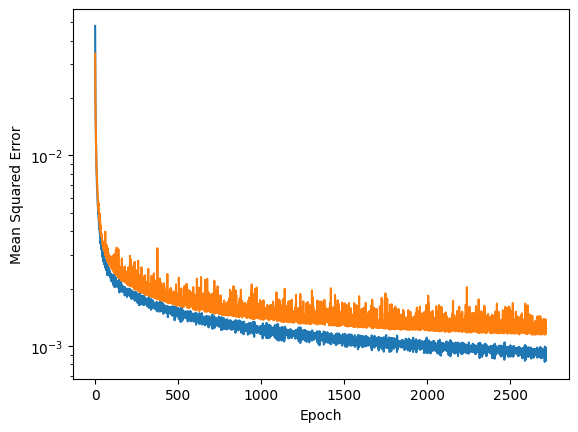

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

In [18]:
model.evaluate(X_val, y_val)

73/73 [==============================] - 0s 858us/step - loss: 0.0012


0.0012406202731654048

# Optimization

In [19]:
import os

import thirdParty.platypusModV2 as plat

In [20]:
mainDir = '03_rbfRuns/'

CFDNNetAdapt.prepOutDir(mainDir)

ls = os.listdir(mainDir)
ls = sorted([i for i in ls if "run" in i])
try:
    lastRunNum = int(ls[-1].split("_")[-1])
    runDir = mainDir + f"run_{(lastRunNum + 1):02d}/"
except:
    runDir = mainDir + f"run_{(len(ls) + 1):02d}/"

In [21]:
CFDNNetAdapt.prepOutDir(runDir)
stepDir = runDir + "step_0001/"
CFDNNetAdapt.prepOutDir(stepDir)
netDir = stepDir + f"{n_inputs}_{n_hidden_neurons}_{n_outputs}/"
CFDNNetAdapt.prepOutDir(netDir)
model.save(netDir + "model.keras")

In [22]:
smpDir = "../00_prepCFDData/"
prbDir="14_LConv2CPLDiff4CP/"
dataNm="10_platypusCFDAllSolutions.dat"
minMax="12_minMaxAng.dat"

In [23]:
from src.evalFunctions import dnnEvaluationCDSO as dnnEvaluation

In [24]:
pMin=0.0
pMax=1.0

In [25]:
problem = plat.Problem(n_inputs, n_objectives)
problem.types[:] = [plat.Real(pMin, pMax)] * n_inputs
problem.function = dnnEvaluation
problem.kwargs = {"nets": [model], "lm_optimizer": False, "smpMins": smpMins,
                  "smpMaxs": smpMaxs, "nObjs": n_objectives, "nOuts": n_outputs, "smpDir": smpDir,
                  "prbDir": prbDir, "minMax": minMax}

# run the optimization algorithm with archiving data
with plat.MapEvaluator() as evaluator:
    moea = plat.NSGAII(problem, population_size=500, offspring_size=500, evaluator=evaluator,
                       archive=plat.Archive())
    moea.run(60 * 500)

In [26]:
# read samples
source, target = CFDNNetAdapt.loadAndScaleData(smpDir + prbDir, dataNm, n_inputs, n_objectives)
source.shape, target.shape

((14, 7731), (2, 7731))

In [27]:
# rescale samples
xs = list()
ys = list()
for i in range(len(target[0])):
    xs.append(
        target[0][i] * (smpMaxs[n_inputs + 0] - smpMins[n_inputs + 0]) + smpMins[n_inputs + 0])
    ys.append(
        target[1][i] * (smpMaxs[n_inputs + 1] - smpMins[n_inputs + 1]) + smpMins[n_inputs + 1])

[0.43090436515673436, 0.4358807629907065, 0.6707564390289709, 0.3928044211165821, 0.726849319872316, 0.34660665655423994, 0.8902587016008019, 0.2933552032794649, 0.6526821741023261, 0.6865192738089492, 0.6719002863455249, 0.8874087132150057, 0.01534821306960539, 0.03658355718382207] [0.14713164, 0.03976873410345873]
[0.43090436515673436, 0.4358807629907065, 0.6707564390289709, 0.3928044211165821, 0.726849319872316, 0.34660665655423994, 0.8902587016008019, 0.2933552032794649, 0.6526821741023261, 0.6865192738089492, 0.6719002863455249, 0.8874087132150057, 0.01534821306960539, 0.03658355718382207] [0.14713164, 0.03976873410345873]
[0.43090436515673436, 0.4358807629907065, 0.6707564390289709, 0.3928044211165821, 0.726849319872316, 0.34660665655423994, 0.8902587016008019, 0.2933552032794649, 0.6526821741023261, 0.6865192738089492, 0.6719002863455249, 0.8874087132150057, 0.01534821306960539, 0.03658355718382207] [0.14713164, 0.03976873410345873]
[0.43090436515673436, 0.4358807629907065, 0.67

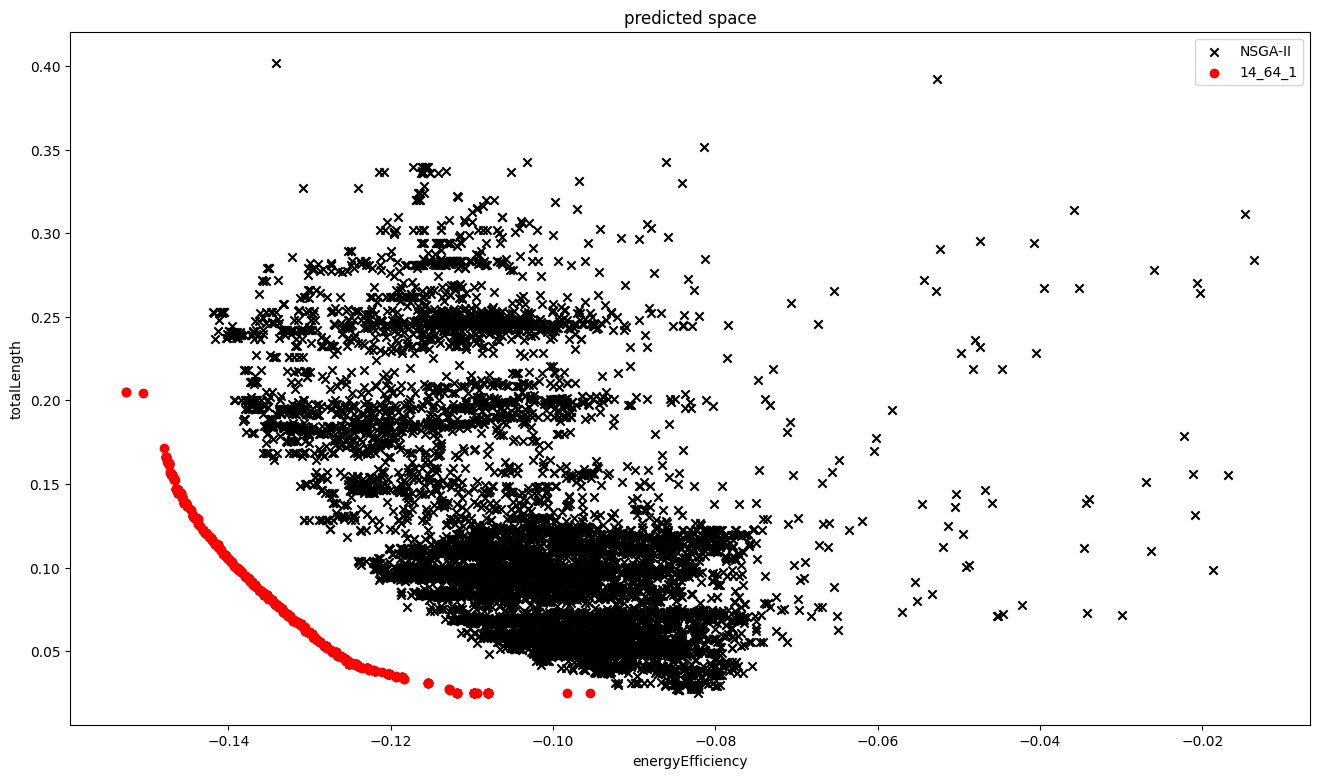

In [28]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

# plot sampels
ax.scatter(xs, ys, label="NSGA-II", color="black", marker="x")

xs = list()
ys = list()

result = moea.result
for i in range(len(result)):
    netPars = result[i].variables[:]
    netOuts = result[i].objectives[:]
    print(netPars, netOuts)

    # concatenate and descale
    data = netPars + netOuts
    data = np.array(data)
    data = data * (smpMaxs - smpMins) + smpMins

    # values predicted by DNN
    xs.append(data[n_inputs + 0])
    ys.append(data[n_inputs + 1])

ax.scatter(xs, ys, label=f"{n_inputs}_{n_hidden_neurons}_{n_outputs}", color="red", marker="o")

# finish plot
xName = "energyEfficiency"
yName = "totalLength"
ax.set_xlabel(xName)
ax.set_ylabel(yName)

ax.set_title("predicted space")

plt.legend()
plt.savefig(runDir + "objSpacePlot.png")
plt.show()

In [29]:
plt.savefig(runDir + "objSpacePlot.png")

<Figure size 640x480 with 0 Axes>